In [1]:
BATCH_SIZE = 48 #How many pics are processed one time
EDGE_CROP = 16 #Not used yet
GAUSSIAN_NOISE = 0.1 # ?
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1) #?
# downsampling in preprocessing
IMG_SCALING = (3, 3) #?
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

In [2]:
import tensorflow as tf
hello = tf.constant('hi,tensorflow')
sess = tf.Session()

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt # data visualization
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util.montage import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # use GPU or CPU to train
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../Ship_detectT9'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2: # img dimension
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [4]:
masks = pd.read_csv(os.path.join('../Ship_detectT9/', 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...



$$  RLE_0 \stackrel{Decode}{\longrightarrow} \textrm{Image}_0 \stackrel{Encode}{\longrightarrow} RLE_1 \stackrel{Decode}{\longrightarrow} \textrm{Image}_1 $$

$ \textrm{Image}_0 \stackrel{?}{=} \textrm{Image}_1 $




Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


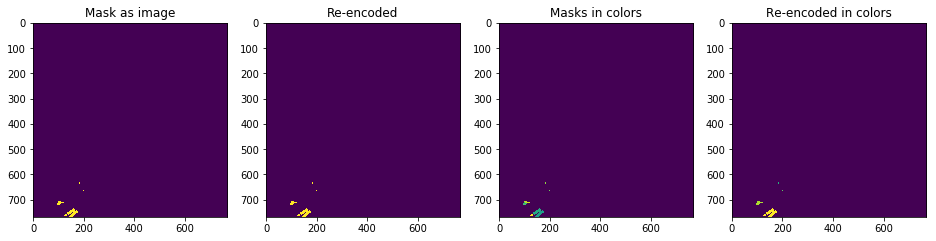

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
189998,fc97c9bca.jpg,0,0.0,[0.0],123.574219
99241,8407a6bf8.jpg,0,0.0,[0.0],92.044922
59443,4f4bfdd9a.jpg,0,0.0,[0.0],114.776367
13814,1253d8605.jpg,0,0.0,[0.0],112.625000
74558,631e6babf.jpg,0,0.0,[0.0],96.807617
140269,ba5da53b9.jpg,0,0.0,[0.0],117.694336
132959,b0c3baf37.jpg,0,0.0,[0.0],88.403320


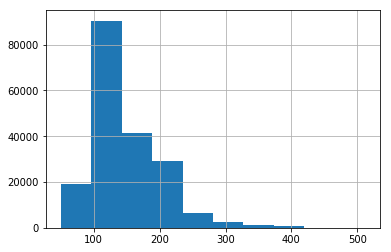

In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

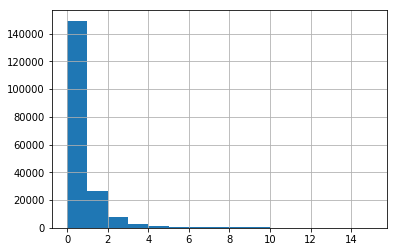

In [7]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

# Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

191289 masks


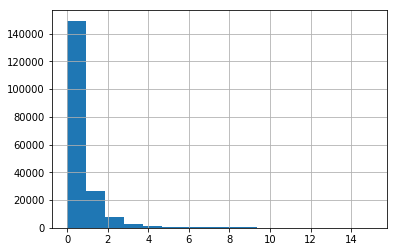

In [8]:
SAMPLES_PER_GROUP = 170000 # influence most on groups that doesn't contain ships
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [9]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

184071 training masks
46011 validation masks


# Decode all the RLEs into Images
We make a generator to produce batches of images

In [10]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [11]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


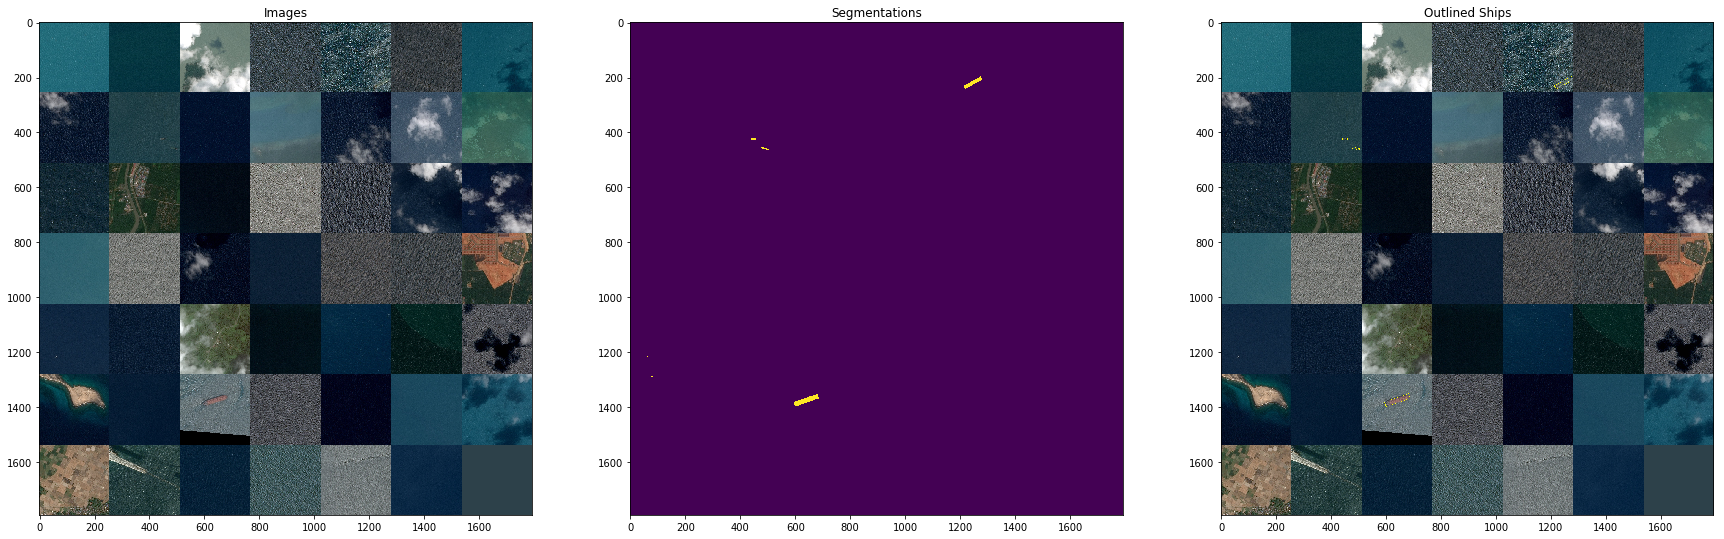

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Make the Validation Set

In [13]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)
CPU times: user 14.7 s, sys: 1.56 s, total: 16.2 s
Wall time: 36.5 s


# Augment Data

In [14]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

Using TensorFlow backend.


x (48, 256, 256, 3) float64 0.0 1.0
y (48, 256, 256, 1) uint8 0 1


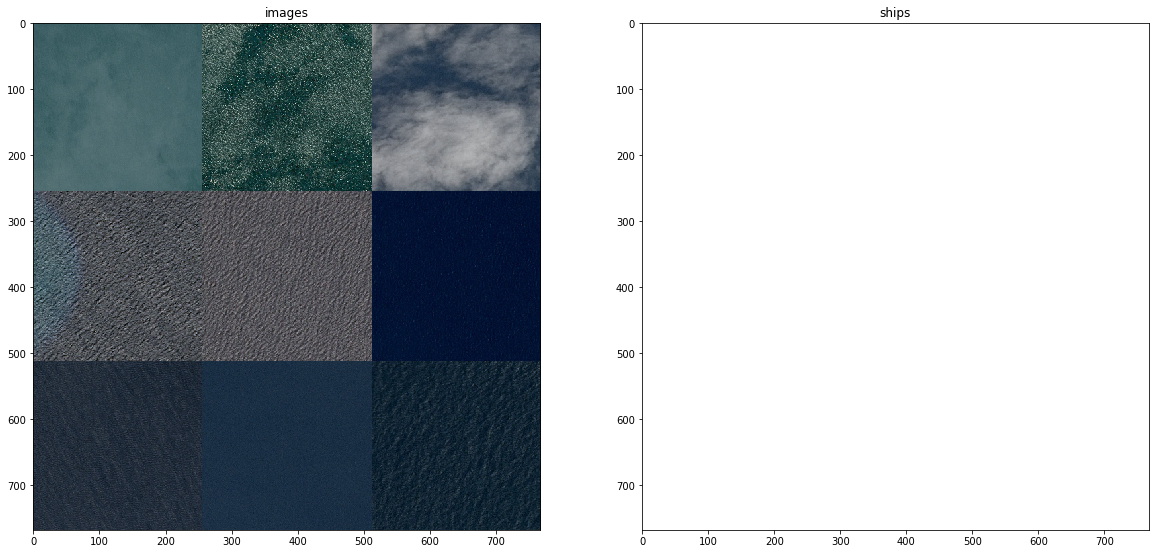

In [17]:
cur_gen = train_gen
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [18]:
gc.collect()

470

# Build a Model
Here we use a slight deviation on the U-Net standard

In [19]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
RGB_Input (InputLayer)           (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
average_pooling2d_1 (AveragePool (None, 256, 256, 3)   0           RGB_Input[0][0]                  
____________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise) (None, 256, 256, 3)   0           average_pooling2d_1[0][0]        
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 256, 256, 3)   12          gaussian_noise_1[0][0]           
___________________________________________________________________________________________

In [20]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [21]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min', cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=40) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [22]:
def fit():
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=IoU, metrics=['binary_accuracy'])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = make_image_gen(train_df)
    loss_history = [seg_model.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < -0.0017:
        break

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/99
9/9 [==============================] - 41s - loss: -0.0016 - binary_accuracy: 0.0015 - val_loss: -0.0012 - val_binary_accuracy: 0.0011
Epoch 2/99
9/9 [==============================] - 13s - loss: -0.0022 - binary_accuracy: 0.0017 - val_loss: -0.0015 - val_binary_accuracy: 0.0034
Epoch 3/99
9/9 [==============================] - 14s - loss: -0.0014 - binary_accuracy: 0.0948 - val_loss: -0.0018 - val_binary_accuracy: 0.5323
Epoch 4/99
9/9 [==============================] - 14s - loss: -0.0020 - binary_accuracy: 0.7087 - val_loss: -0.0018 - val_binary_accuracy: 0.6089
Epoch 5/99
8/9 [=========================>....] - ETA: 1s - loss: -0.0019 - binary_accuracy: 0.5081Epoch 00004: val_loss did not improve

Epoch 00004: reducing learning rate to 0.00033000001567415896.
9/9 [==============================] - 14s - loss: -0.0021 - binary_a

9/9 [==============================] - 15s - loss: -0.0018 - binary_accuracy: 0.5760 - val_loss: -0.0019 - val_binary_accuracy: 0.6775
Epoch 22/99
9/9 [==============================] - 23s - loss: -0.0019 - binary_accuracy: 0.5741 - val_loss: -0.0019 - val_binary_accuracy: 0.6763
Epoch 23/99
9/9 [==============================] - 17s - loss: -0.0020 - binary_accuracy: 0.5914 - val_loss: -0.0019 - val_binary_accuracy: 0.6744
Epoch 24/99
9/9 [==============================] - 13s - loss: -0.0020 - binary_accuracy: 0.5936 - val_loss: -0.0019 - val_binary_accuracy: 0.6754
Epoch 25/99
9/9 [==============================] - 13s - loss: -0.0018 - binary_accuracy: 0.5870 - val_loss: -0.0019 - val_binary_accuracy: 0.6763
Epoch 26/99
9/9 [==============================] - 13s - loss: -0.0021 - binary_accuracy: 0.5965 - val_loss: -0.0019 - val_binary_accuracy: 0.6762
Epoch 27/99
9/9 [==============================] - 13s - loss: -0.0018 - binary_accuracy: 0.6095 - val_loss: -0.0019 - val_binary_

9/9 [==============================] - 13s - loss: -0.0018 - binary_accuracy: 0.5898 - val_loss: -0.0019 - val_binary_accuracy: 0.6643
Epoch 47/99
9/9 [==============================] - 13s - loss: -0.0019 - binary_accuracy: 0.5725 - val_loss: -0.0019 - val_binary_accuracy: 0.6659
Epoch 48/99
9/9 [==============================] - 13s - loss: -0.0020 - binary_accuracy: 0.5845 - val_loss: -0.0019 - val_binary_accuracy: 0.6654
Epoch 49/99
9/9 [==============================] - 14s - loss: -0.0021 - binary_accuracy: 0.5746 - val_loss: -0.0019 - val_binary_accuracy: 0.6648
Epoch 50/99
9/9 [==============================] - 13s - loss: -0.0018 - binary_accuracy: 0.6036 - val_loss: -0.0019 - val_binary_accuracy: 0.6636
Epoch 51/99
9/9 [==============================] - 14s - loss: -0.0024 - binary_accuracy: 0.5718 - val_loss: -0.0019 - val_binary_accuracy: 0.6634
Epoch 52/99
9/9 [==============================] - 13s - loss: -0.0016 - binary_accuracy: 0.5649 - val_loss: -0.0019 - val_binary_

9/9 [==============================] - 13s - loss: -0.0020 - binary_accuracy: 0.5990 - val_loss: -0.0019 - val_binary_accuracy: 0.6581
Epoch 77/99
9/9 [==============================] - 14s - loss: -0.0021 - binary_accuracy: 0.5843 - val_loss: -0.0019 - val_binary_accuracy: 0.6580
Epoch 78/99
9/9 [==============================] - 15s - loss: -0.0017 - binary_accuracy: 0.5893 - val_loss: -0.0019 - val_binary_accuracy: 0.6578
Epoch 79/99
9/9 [==============================] - 13s - loss: -0.0016 - binary_accuracy: 0.5848 - val_loss: -0.0019 - val_binary_accuracy: 0.6578
Epoch 80/99
9/9 [==============================] - 14s - loss: -0.0020 - binary_accuracy: 0.5981 - val_loss: -0.0019 - val_binary_accuracy: 0.6586
Epoch 00079: early stopping


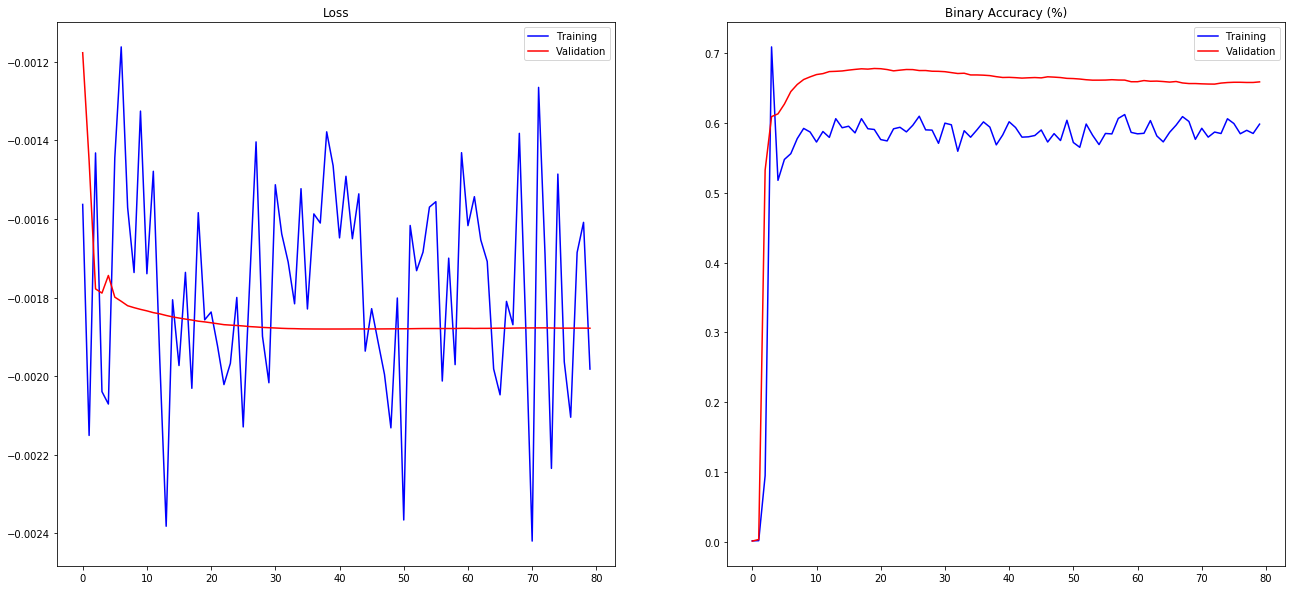

In [23]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_binary_accuracy'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')

show_loss(loss_history)

In [24]:
seg_model.load_weights(weight_path)
seg_model.save('seg_model.h5')

In [25]:
pred_y = seg_model.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(900, 256, 256, 1) 0.49061215 0.9661669 0.6006791


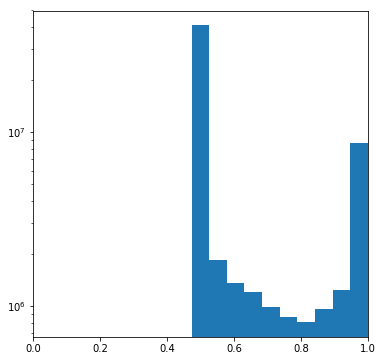

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

# Prepare Full Resolution Model
Here we account for the scaling so everything can happen in the model itself

In [27]:
if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(seg_model)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = seg_model
fullres_model.save('fullres_model.h5')

# Visualize predictions

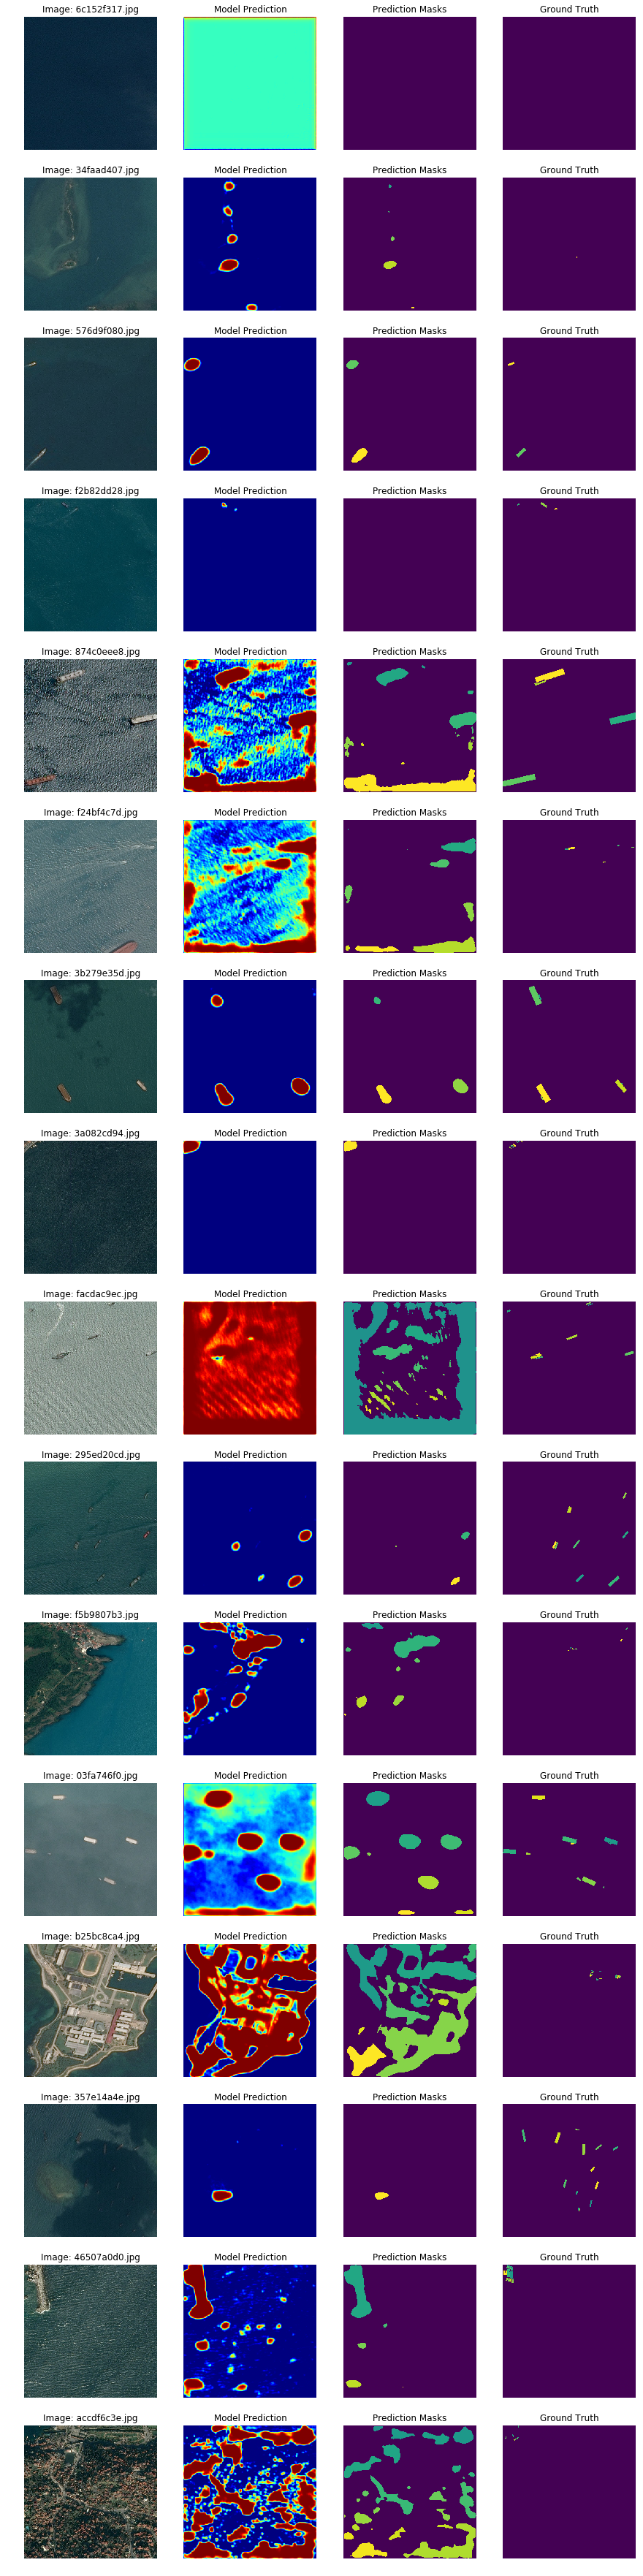

In [28]:
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')